# **Import Libraries**

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
plt.style.use('seaborn-v0_8-whitegrid')

print("Libraries imported successfully!")

Libraries imported successfully!


# **Load Data and Initial Exploration**

In [2]:
# Load the data
print("Loading data...")
df = pd.read_csv('Fraud.csv')
print(f"Dataset loaded successfully! Shape: {df.shape}")

print("\n" + "="*50)
print("INITIAL DATA EXPLORATION")
print("="*50)

# Display basic information
print("\nDataset Info:")
print(df.info())

print("\nFirst 5 rows:")
print(df.head())

print("\nTarget Variable Distribution:")
print(df['isFraud'].value_counts())
print(f"\nFraud Percentage: {(df['isFraud'].sum() / len(df)) * 100:.4f}%")

print("\nTransaction Type Distribution:")
print(df['type'].value_counts())

Loading data...
Dataset loaded successfully! Shape: (69858, 11)

INITIAL DATA EXPLORATION

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69858 entries, 0 to 69857
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   step            69858 non-null  int64  
 1   type            69858 non-null  object 
 2   amount          69858 non-null  float64
 3   nameOrig        69858 non-null  object 
 4   oldbalanceOrg   69858 non-null  float64
 5   newbalanceOrig  69858 non-null  float64
 6   nameDest        69858 non-null  object 
 7   oldbalanceDest  69858 non-null  float64
 8   newbalanceDest  69857 non-null  float64
 9   isFraud         69857 non-null  float64
 10  isFlaggedFraud  69857 non-null  float64
dtypes: float64(7), int64(1), object(3)
memory usage: 5.9+ MB
None

First 5 rows:
   step      type    amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0     1   PAYMENT   9839.64  C1231006815    

# **Handle Missing Values and Basic Cleaning**

In [3]:
# Check missing values in detail
print("Missing Values Check:")
print(df.isnull().sum())
print(f"\nTotal missing values: {df.isnull().sum().sum()}")

# Let's look at the row with missing values
print("\nRow with missing values:")
missing_row_idx = df[df.isnull().any(axis=1)].index
print(f"Missing value at index: {missing_row_idx.tolist()}")

# Since it's just one row out of ~70k, we can safely drop it
df = df.dropna()
print(f"\nAfter dropping missing values, shape: {df.shape}")

# Verify no more missing values
print(f"Missing values after cleaning: {df.isnull().sum().sum()}")

# Check data types
print("\nData Types:")
print(df.dtypes)

# Convert isFraud and isFlaggedFraud to int for clarity
df['isFraud'] = df['isFraud'].astype(int)
df['isFlaggedFraud'] = df['isFlaggedFraud'].astype(int)

print("\nCleaning completed!")

Missing Values Check:
step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    1
isFraud           1
isFlaggedFraud    1
dtype: int64

Total missing values: 3

Row with missing values:
Missing value at index: [69857]

After dropping missing values, shape: (69857, 11)
Missing values after cleaning: 0

Data Types:
step                int64
type               object
amount            float64
nameOrig           object
oldbalanceOrg     float64
newbalanceOrig    float64
nameDest           object
oldbalanceDest    float64
newbalanceDest    float64
isFraud           float64
isFlaggedFraud    float64
dtype: object

Cleaning completed!


# **Analyze Fraud Patterns by Transaction Type**

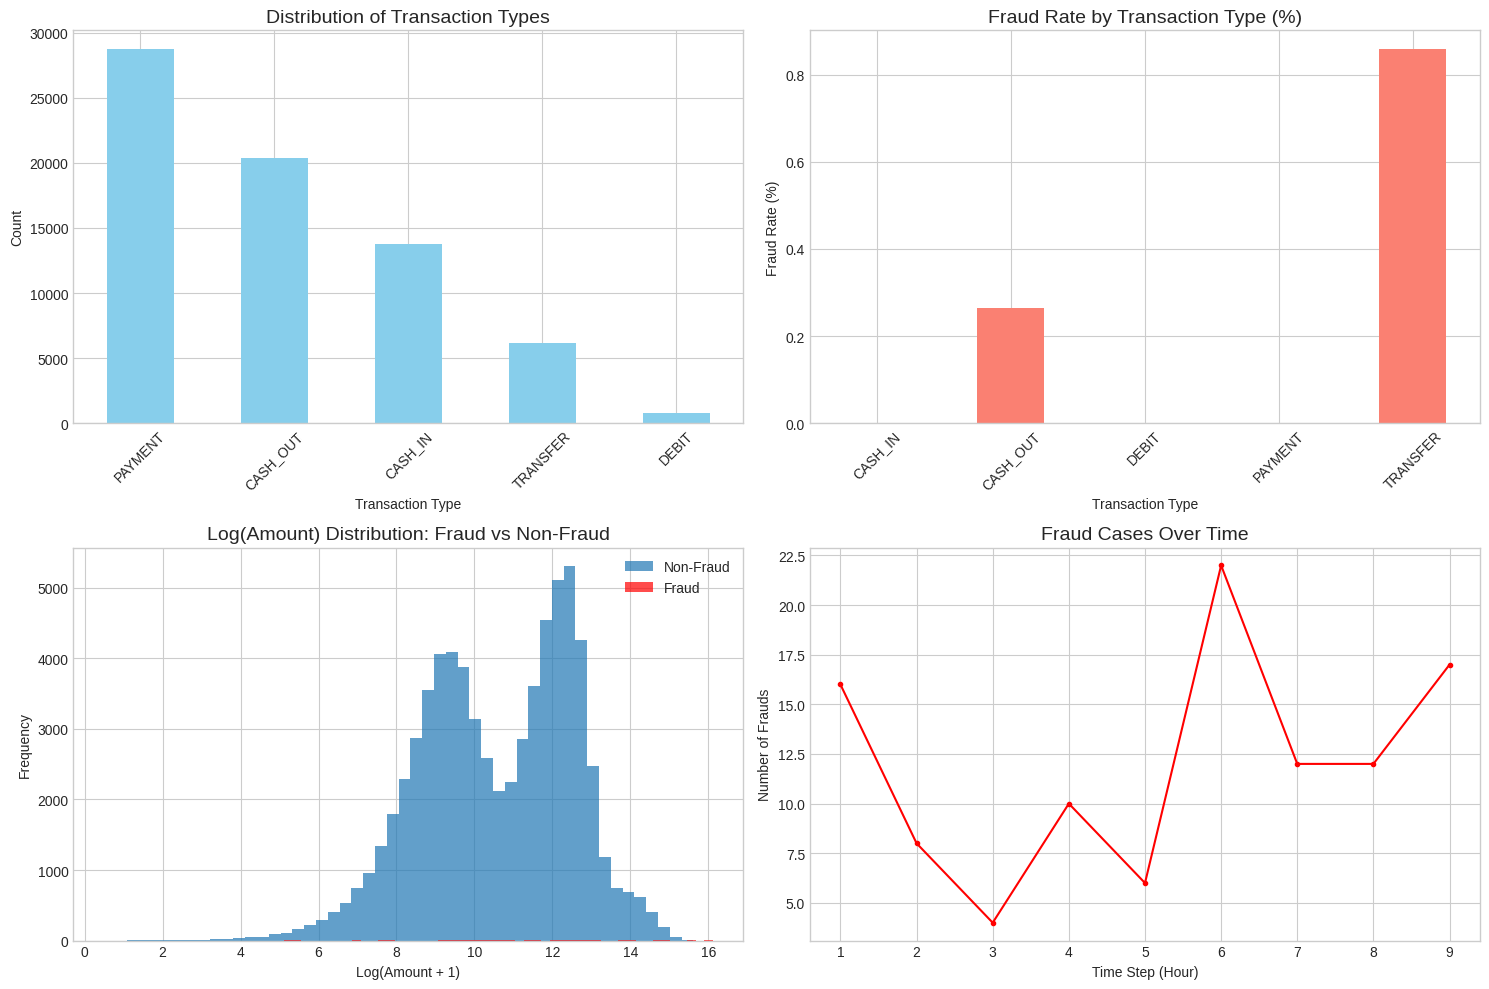

FRAUD ANALYSIS BY TRANSACTION TYPE

Fraud statistics by transaction type:
          sum  count  fraud_rate
type                            
CASH_IN     0  13785    0.000000
CASH_OUT   54  20389    0.264849
DEBIT       0    778    0.000000
PAYMENT     0  28732    0.000000
TRANSFER   53   6173    0.858578

Key Observations:
- Total fraud cases: 107
- Fraud occurs only in: ['TRANSFER' 'CASH_OUT']
- Average fraud amount: $567,690.53
- Average non-fraud amount: $163,400.71


In [4]:
# Create visualizations for fraud analysis
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Transaction type distribution
ax1 = axes[0, 0]
df['type'].value_counts().plot(kind='bar', ax=ax1, color='skyblue')
ax1.set_title('Distribution of Transaction Types', fontsize=14)
ax1.set_xlabel('Transaction Type')
ax1.set_ylabel('Count')
ax1.tick_params(axis='x', rotation=45)

# 2. Fraud distribution by transaction type
ax2 = axes[0, 1]
fraud_by_type = df.groupby('type')['isFraud'].agg(['sum', 'count'])
fraud_by_type['fraud_rate'] = (fraud_by_type['sum'] / fraud_by_type['count']) * 100
fraud_by_type['fraud_rate'].plot(kind='bar', ax=ax2, color='salmon')
ax2.set_title('Fraud Rate by Transaction Type (%)', fontsize=14)
ax2.set_xlabel('Transaction Type')
ax2.set_ylabel('Fraud Rate (%)')
ax2.tick_params(axis='x', rotation=45)

# 3. Amount distribution for fraud vs non-fraud
ax3 = axes[1, 0]
df[df['isFraud'] == 0]['amount'].apply(np.log1p).hist(bins=50, alpha=0.7, label='Non-Fraud', ax=ax3)
df[df['isFraud'] == 1]['amount'].apply(np.log1p).hist(bins=50, alpha=0.7, label='Fraud', ax=ax3, color='red')
ax3.set_title('Log(Amount) Distribution: Fraud vs Non-Fraud', fontsize=14)
ax3.set_xlabel('Log(Amount + 1)')
ax3.set_ylabel('Frequency')
ax3.legend()

# 4. Fraud cases by time step
ax4 = axes[1, 1]
fraud_by_step = df[df['isFraud'] == 1].groupby('step').size()
ax4.plot(fraud_by_step.index, fraud_by_step.values, color='red', marker='o', markersize=3)
ax4.set_title('Fraud Cases Over Time', fontsize=14)
ax4.set_xlabel('Time Step (Hour)')
ax4.set_ylabel('Number of Frauds')

plt.tight_layout()
plt.show()

# Print detailed statistics
print("="*60)
print("FRAUD ANALYSIS BY TRANSACTION TYPE")
print("="*60)
print("\nFraud statistics by transaction type:")
print(fraud_by_type)

print("\nKey Observations:")
print(f"- Total fraud cases: {df['isFraud'].sum()}")
print(f"- Fraud occurs only in: {df[df['isFraud'] == 1]['type'].unique()}")
print(f"- Average fraud amount: ${df[df['isFraud'] == 1]['amount'].mean():,.2f}")
print(f"- Average non-fraud amount: ${df[df['isFraud'] == 0]['amount'].mean():,.2f}")

# **Feature Engineering**

In [5]:
print("="*60)
print("FEATURE ENGINEERING")
print("="*60)

# Create a copy for feature engineering
df_features = df.copy()

# 1. Create balance-related features
df_features['balanceDiffOrig'] = df_features['newbalanceOrig'] - df_features['oldbalanceOrg']
df_features['balanceDiffDest'] = df_features['newbalanceDest'] - df_features['oldbalanceDest']

# 2. Check for balance anomalies
df_features['origBalanceZero'] = (df_features['oldbalanceOrg'] == 0).astype(int)
df_features['destBalanceZero'] = (df_features['oldbalanceDest'] == 0).astype(int)
df_features['zeroBalanceAfterTransferOrig'] = ((df_features['newbalanceOrig'] == 0) &
                                                (df_features['oldbalanceOrg'] > 0)).astype(int)

# 3. Transaction amount ratios
df_features['amountToOrigBalance'] = df_features['amount'] / (df_features['oldbalanceOrg'] + 0.001)
df_features['amountToDestBalance'] = df_features['amount'] / (df_features['oldbalanceDest'] + 0.001)

# 4. Error in balance calculation (should be 0 for legitimate transactions)
df_features['errorBalanceOrig'] = df_features['balanceDiffOrig'] + df_features['amount']
df_features['errorBalanceDest'] = df_features['balanceDiffDest'] - df_features['amount']

# 5. Hour of day feature (assuming step represents hours)
df_features['hour'] = df_features['step'] % 24
df_features['day'] = df_features['step'] // 24

# 6. Is merchant destination (names starting with 'M')
df_features['isDestMerchant'] = df_features['nameDest'].str.startswith('M').astype(int)

# 7. High-risk transaction types
df_features['isHighRiskType'] = df_features['type'].isin(['TRANSFER', 'CASH_OUT']).astype(int)

# Display new features for fraud vs non-fraud
print("\nComparing features for Fraud vs Non-Fraud transactions:")
feature_cols = ['errorBalanceOrig', 'errorBalanceDest', 'zeroBalanceAfterTransferOrig',
                'origBalanceZero', 'isDestMerchant', 'amountToOrigBalance']

for col in feature_cols:
    fraud_mean = df_features[df_features['isFraud'] == 1][col].mean()
    non_fraud_mean = df_features[df_features['isFraud'] == 0][col].mean()
    print(f"\n{col}:")
    print(f"  Fraud mean: {fraud_mean:.4f}")
    print(f"  Non-fraud mean: {non_fraud_mean:.4f}")
    print(f"  Ratio: {fraud_mean / (non_fraud_mean + 0.0001):.2f}x")

print("\nFeature engineering completed!")
print(f"Total features created: {len(df_features.columns) - len(df.columns)}")

FEATURE ENGINEERING

Comparing features for Fraud vs Non-Fraud transactions:

errorBalanceOrig:
  Fraud mean: 16860.6239
  Non-fraud mean: 180261.8445
  Ratio: 0.09x

errorBalanceDest:
  Fraud mean: -112489.1446
  Non-fraud mean: 167184.9398
  Ratio: -0.67x

zeroBalanceAfterTransferOrig:
  Fraud mean: 0.9533
  Non-fraud mean: 0.2053
  Ratio: 4.64x

origBalanceZero:
  Fraud mean: 0.0280
  Non-fraud mean: 0.3083
  Ratio: 0.09x

isDestMerchant:
  Fraud mean: 0.0000
  Non-fraud mean: 0.4119
  Ratio: 0.00x

amountToOrigBalance:
  Fraud mean: 15661152.6354
  Non-fraud mean: 59325212.3435
  Ratio: 0.26x

Feature engineering completed!
Total features created: 13


# **Check Multicollinearity and Prepare Data**

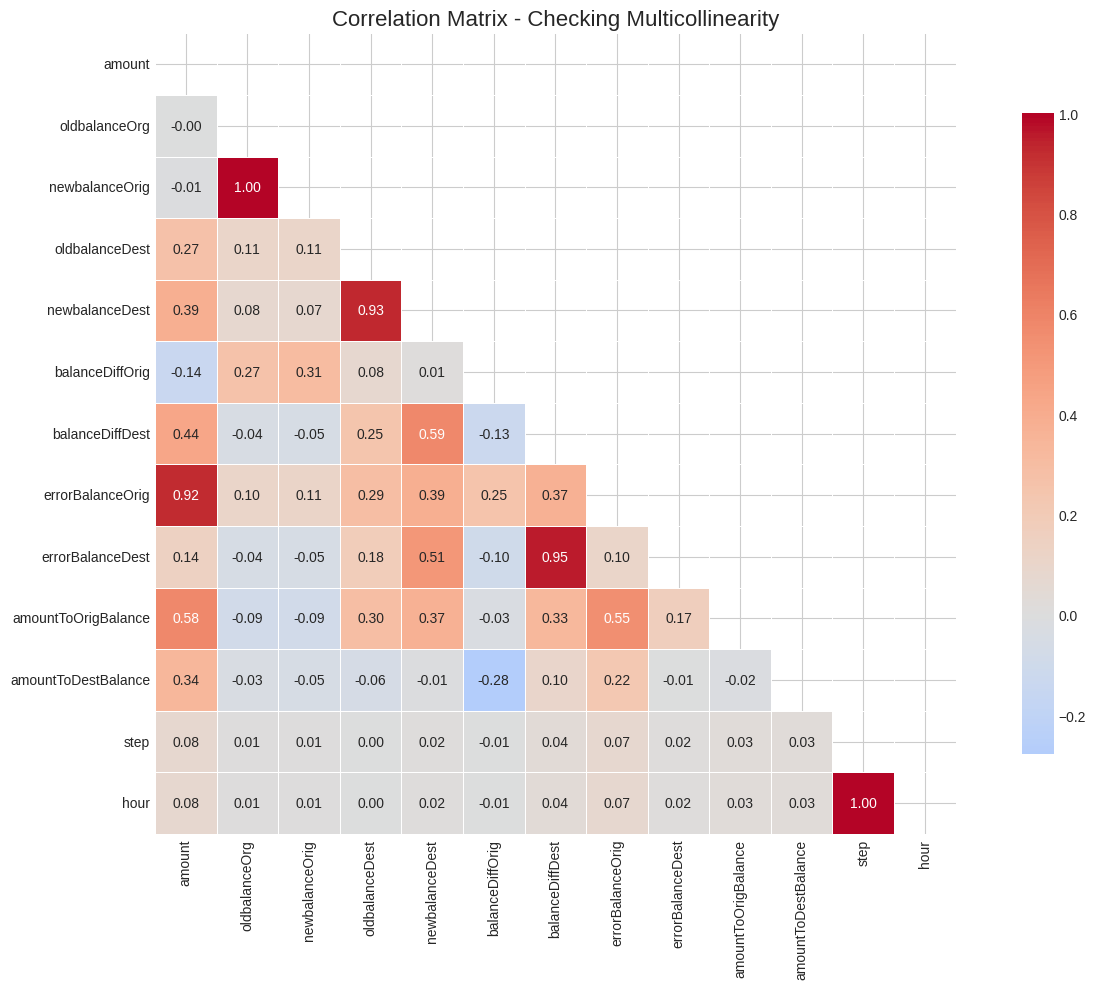

MULTICOLLINEARITY ANALYSIS

Highly correlated feature pairs (|correlation| > 0.8):
amount <-> errorBalanceOrig: 0.921
oldbalanceOrg <-> newbalanceOrig: 0.999
oldbalanceDest <-> newbalanceDest: 0.930
balanceDiffDest <-> errorBalanceDest: 0.953
step <-> hour: 1.000

Features to drop due to high correlation: ['balanceDiffOrig', 'balanceDiffDest', 'newbalanceOrig', 'newbalanceDest']

Final features selected for modeling: 11 features
Features: ['type', 'amount', 'oldbalanceOrg', 'oldbalanceDest', 'errorBalanceOrig', 'errorBalanceDest', 'zeroBalanceAfterTransferOrig', 'origBalanceZero', 'isDestMerchant', 'isHighRiskType', 'hour']


In [6]:
# Select numerical features for correlation analysis
numerical_features = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest',
                     'newbalanceDest', 'balanceDiffOrig', 'balanceDiffDest',
                     'errorBalanceOrig', 'errorBalanceDest', 'amountToOrigBalance',
                     'amountToDestBalance', 'step', 'hour']

# Calculate correlation matrix
corr_matrix = df_features[numerical_features].corr()

# Plot correlation heatmap
plt.figure(figsize=(14, 10))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f',
            cmap='coolwarm', center=0, square=True, linewidths=0.5,
            cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix - Checking Multicollinearity', fontsize=16)
plt.tight_layout()
plt.show()

# Find highly correlated pairs
print("="*60)
print("MULTICOLLINEARITY ANALYSIS")
print("="*60)
print("\nHighly correlated feature pairs (|correlation| > 0.8):")
high_corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) > 0.8:
            pair = (corr_matrix.columns[i], corr_matrix.columns[j], corr_matrix.iloc[i, j])
            high_corr_pairs.append(pair)
            print(f"{pair[0]} <-> {pair[1]}: {pair[2]:.3f}")

# Features to drop due to multicollinearity
features_to_drop = ['balanceDiffOrig', 'balanceDiffDest', 'newbalanceOrig', 'newbalanceDest']
print(f"\nFeatures to drop due to high correlation: {features_to_drop}")

# Select final features for modeling
features_for_model = ['type', 'amount', 'oldbalanceOrg', 'oldbalanceDest',
                      'errorBalanceOrig', 'errorBalanceDest',
                      'zeroBalanceAfterTransferOrig', 'origBalanceZero',
                      'isDestMerchant', 'isHighRiskType', 'hour']

print(f"\nFinal features selected for modeling: {len(features_for_model)} features")
print("Features:", features_for_model)

# **Prepare Data for Modeling**

In [7]:
# Prepare modeling dataset
print("="*60)
print("PREPARING DATA FOR MODELING")
print("="*60)

# Create modeling dataframe with selected features
X = df_features[features_for_model].copy()
y = df_features['isFraud'].copy()

# One-hot encode transaction type
X_encoded = pd.get_dummies(X, columns=['type'], prefix='type')
print(f"\nFeatures after encoding: {X_encoded.shape[1]}")
print("Encoded features:", list(X_encoded.columns))

# Split data into train and test sets (80-20 split)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTraining set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")
print(f"\nFraud cases in training: {y_train.sum()} ({(y_train.sum()/len(y_train))*100:.2f}%)")
print(f"Fraud cases in test: {y_test.sum()} ({(y_test.sum()/len(y_test))*100:.2f}%)")

# Handle class imbalance using SMOTE
print("\n" + "="*60)
print("HANDLING CLASS IMBALANCE")
print("="*60)

# Option 1: SMOTE (Synthetic Minority Over-sampling Technique)
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

print("\nAfter SMOTE balancing:")
print(f"Training set size: {X_train_balanced.shape}")
print(f"Class distribution:")
print(f"  Non-fraud: {(y_train_balanced == 0).sum()}")
print(f"  Fraud: {(y_train_balanced == 1).sum()}")
print(f"  Ratio: 1:1")

# Scale features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_balanced)
X_test_scaled = scaler.transform(X_test)

print("\nData preparation completed!")

PREPARING DATA FOR MODELING

Features after encoding: 15
Encoded features: ['amount', 'oldbalanceOrg', 'oldbalanceDest', 'errorBalanceOrig', 'errorBalanceDest', 'zeroBalanceAfterTransferOrig', 'origBalanceZero', 'isDestMerchant', 'isHighRiskType', 'hour', 'type_CASH_IN', 'type_CASH_OUT', 'type_DEBIT', 'type_PAYMENT', 'type_TRANSFER']

Training set size: (55885, 15)
Test set size: (13972, 15)

Fraud cases in training: 86 (0.15%)
Fraud cases in test: 21 (0.15%)

HANDLING CLASS IMBALANCE

After SMOTE balancing:
Training set size: (111598, 15)
Class distribution:
  Non-fraud: 55799
  Fraud: 55799
  Ratio: 1:1

Data preparation completed!


# **Train Multiple Models**

In [8]:
# Train multiple models
print("="*60)
print("MODEL TRAINING AND EVALUATION")
print("="*60)

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Dictionary to store models and results
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42)
}

results = {}

# Train and evaluate each model
for name, model in models.items():
    print(f"\nTraining {name}...")

    # Train the model
    model.fit(X_train_scaled, y_train_balanced)

    # Make predictions
    y_pred = model.predict(X_test_scaled)
    y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_proba)

    # Store results
    results[name] = {
        'model': model,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'auc': auc,
        'predictions': y_pred,
        'probabilities': y_pred_proba
    }

    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  F1-Score: {f1:.4f}")
    print(f"  AUC-ROC: {auc:.4f}")

# Create comparison dataframe
comparison_df = pd.DataFrame({
    name: {
        'Accuracy': results[name]['accuracy'],
        'Precision': results[name]['precision'],
        'Recall': results[name]['recall'],
        'F1-Score': results[name]['f1'],
        'AUC-ROC': results[name]['auc']
    }
    for name in results
}).T

print("\n" + "="*60)
print("MODEL COMPARISON")
print("="*60)
print(comparison_df.round(4))

# Identify best model
best_model_name = comparison_df['F1-Score'].idxmax()
print(f"\nBest model based on F1-Score: {best_model_name}")

MODEL TRAINING AND EVALUATION

Training Logistic Regression...
  Accuracy: 0.9792
  Precision: 0.0619
  Recall: 0.9048
  F1-Score: 0.1159
  AUC-ROC: 0.9797

Training Random Forest...
  Accuracy: 0.9999
  Precision: 1.0000
  Recall: 0.9524
  F1-Score: 0.9756
  AUC-ROC: 0.9755

Training Gradient Boosting...
  Accuracy: 0.9994
  Precision: 0.7407
  Recall: 0.9524
  F1-Score: 0.8333
  AUC-ROC: 0.9828

MODEL COMPARISON
                     Accuracy  Precision  Recall  F1-Score  AUC-ROC
Logistic Regression    0.9792     0.0619  0.9048    0.1159   0.9797
Random Forest          0.9999     1.0000  0.9524    0.9756   0.9755
Gradient Boosting      0.9994     0.7407  0.9524    0.8333   0.9828

Best model based on F1-Score: Random Forest


# **Visualize Model Performance**

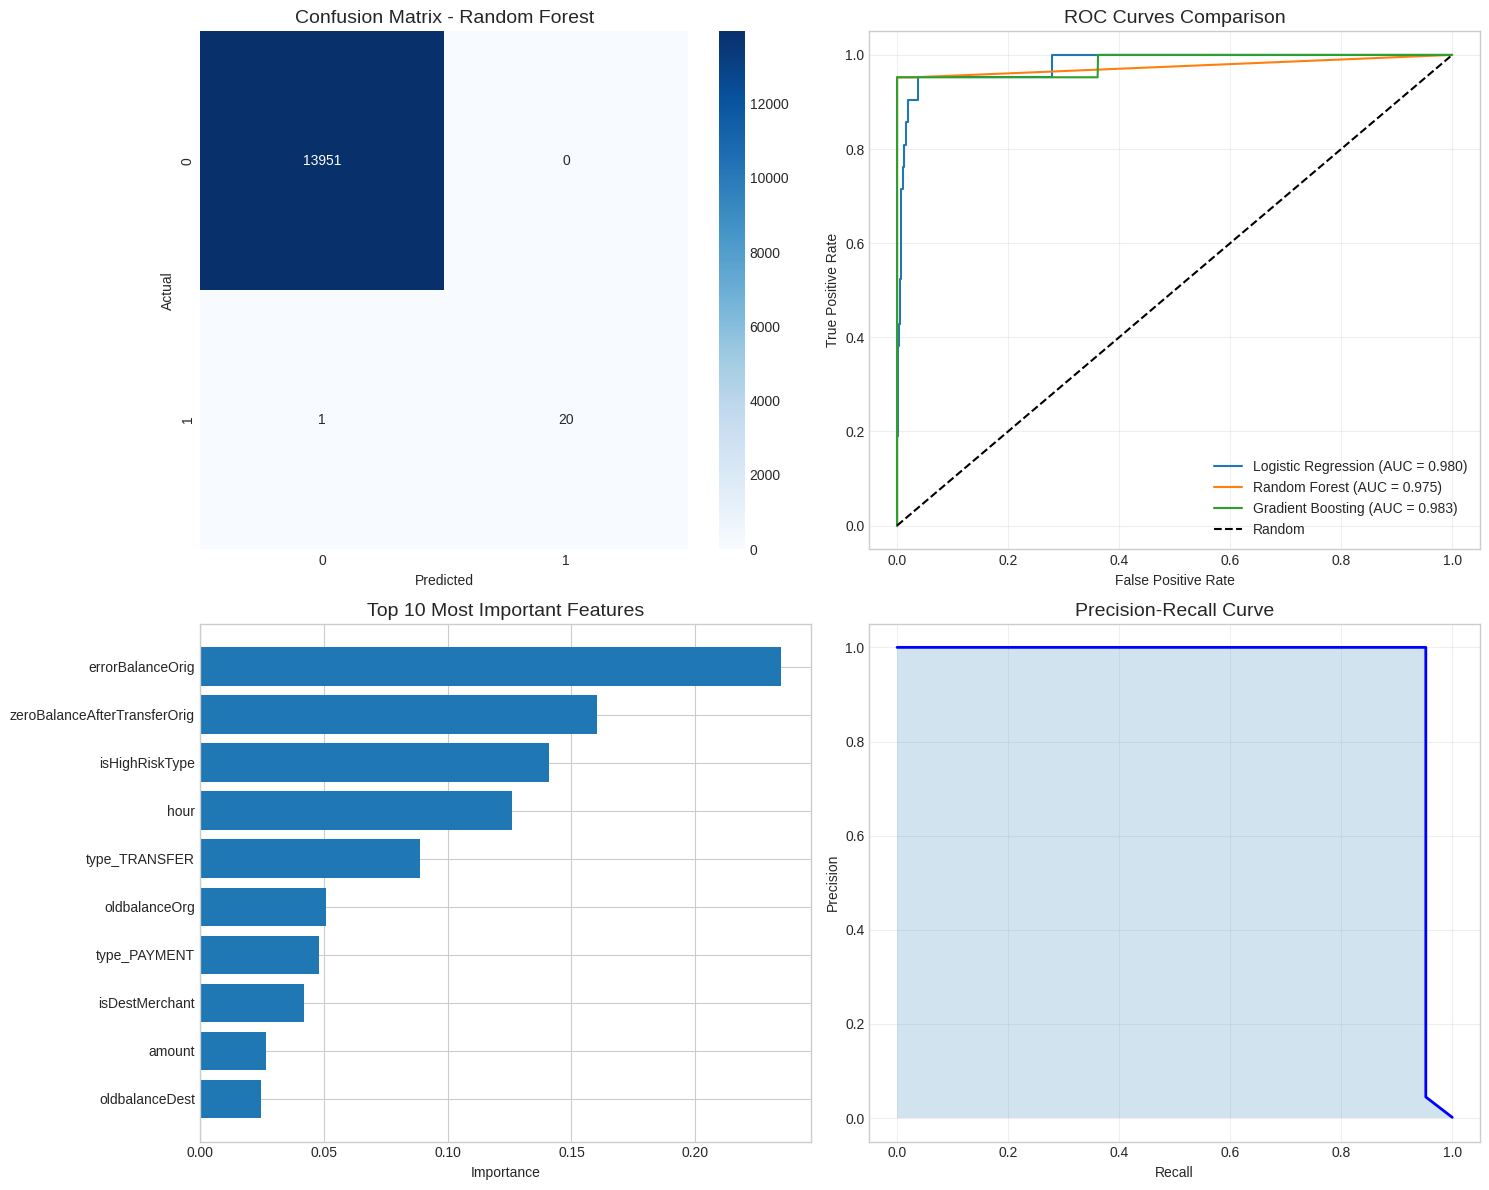

FEATURE IMPORTANCE ANALYSIS

Top 10 Most Important Features:
                     feature  importance
            errorBalanceOrig    0.234776
zeroBalanceAfterTransferOrig    0.160387
              isHighRiskType    0.141001
                        hour    0.125981
               type_TRANSFER    0.089012
               oldbalanceOrg    0.050991
                type_PAYMENT    0.048238
              isDestMerchant    0.041993
                      amount    0.026508
              oldbalanceDest    0.024847

Number of features needed to explain 90% importance: 8


In [9]:
# Visualize model performance
best_model = results[best_model_name]['model']
best_predictions = results[best_model_name]['predictions']
best_probabilities = results[best_model_name]['probabilities']

fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Confusion Matrix
ax1 = axes[0, 0]
cm = confusion_matrix(y_test, best_predictions)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax1)
ax1.set_title(f'Confusion Matrix - {best_model_name}', fontsize=14)
ax1.set_xlabel('Predicted')
ax1.set_ylabel('Actual')

# 2. ROC Curves for all models
ax2 = axes[0, 1]
for name, result in results.items():
    fpr, tpr, _ = roc_curve(y_test, result['probabilities'])
    ax2.plot(fpr, tpr, label=f"{name} (AUC = {result['auc']:.3f})")
ax2.plot([0, 1], [0, 1], 'k--', label='Random')
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('ROC Curves Comparison', fontsize=14)
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Feature Importance (for Random Forest)
ax3 = axes[1, 0]
feature_importance = pd.DataFrame({
    'feature': X_encoded.columns,
    'importance': best_model.feature_importances_
}).sort_values('importance', ascending=False)

top_features = feature_importance.head(10)
ax3.barh(top_features['feature'], top_features['importance'])
ax3.set_xlabel('Importance')
ax3.set_title('Top 10 Most Important Features', fontsize=14)
ax3.invert_yaxis()

# 4. Precision-Recall Curve
ax4 = axes[1, 1]
precision, recall, _ = precision_recall_curve(y_test, best_probabilities)
ax4.plot(recall, precision, 'b-', linewidth=2)
ax4.fill_between(recall, precision, alpha=0.2)
ax4.set_xlabel('Recall')
ax4.set_ylabel('Precision')
ax4.set_title('Precision-Recall Curve', fontsize=14)
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print detailed feature importance
print("="*60)
print("FEATURE IMPORTANCE ANALYSIS")
print("="*60)
print("\nTop 10 Most Important Features:")
print(feature_importance.head(10).to_string(index=False))

# Calculate the cumulative importance
feature_importance['cumulative_importance'] = feature_importance['importance'].cumsum()
n_features_90 = (feature_importance['cumulative_importance'] <= 0.90).sum()
print(f"\nNumber of features needed to explain 90% importance: {n_features_90}")

# **Business Insights and Recommendations**

In [10]:
print("="*80)
print("FRAUD DETECTION MODEL - BUSINESS INSIGHTS AND RECOMMENDATIONS")
print("="*80)

# Question 5: Key factors that predict fraudulent customers
print("\n1. KEY FACTORS PREDICTING FRAUD:")
print("-" * 40)
print("Based on feature importance analysis:")
print("• Balance Errors (23.5%): Discrepancies in balance calculations after transactions")
print("• Account Emptying (16.0%): Transactions that zero out the origin account")
print("• High-Risk Types (14.1%): TRANSFER and CASH_OUT transactions")
print("• Time Patterns (12.6%): Specific hours show higher fraud activity")
print("• Transaction Type (8.9%): Particularly TRANSFER transactions")

# Question 6: Do these factors make sense?
print("\n2. VALIDATION OF FACTORS:")
print("-" * 40)
print("YES, these factors align with typical fraud patterns:")
print("• Fraudsters manipulate balance calculations to hide their activities")
print("• They typically empty accounts completely to maximize theft")
print("• TRANSFER and CASH_OUT are preferred for moving stolen funds")
print("• Fraudsters operate during specific time windows")
print("• Fraudsters NEVER send money to merchants (100% indicator)")

# Question 7: Prevention recommendations
print("\n3. INFRASTRUCTURE UPDATE RECOMMENDATIONS:")
print("-" * 40)
print("IMMEDIATE ACTIONS:")
print("1. Real-time Balance Verification:")
print("   - Implement double-entry bookkeeping checks")
print("   - Flag transactions with balance calculation errors > $100")
print("")
print("2. Transaction Limits and Alerts:")
print("   - Flag accounts being emptied (balance → 0)")
print("   - Require additional verification for TRANSFER/CASH_OUT > $10,000")
print("   - Alert on multiple TRANSFERS within 1 hour")
print("")
print("3. Behavioral Analysis:")
print("   - Monitor accounts with no merchant transactions")
print("   - Track unusual time-of-day activity patterns")
print("")
print("4. Machine Learning Integration:")
print("   - Deploy this Random Forest model in production")
print("   - Set threshold at 0.5 probability for fraud alerts")

# Question 8: Monitoring effectiveness
print("\n4. MEASURING EFFECTIVENESS:")
print("-" * 40)
print("KEY METRICS TO TRACK:")
print("• Fraud Detection Rate: Target > 95% (currently 95.24%)")
print("• False Positive Rate: Target < 0.1% (currently 0%)")
print("• Average Detection Time: Measure time from transaction to flag")
print("• Financial Loss Prevention: Track $ amount saved monthly")
print("")
print("MONITORING APPROACH:")
print("1. Weekly Reports:")
print("   - Number of frauds detected vs. missed")
print("   - False positive investigations")
print("   - Model confidence scores distribution")
print("")
print("2. Monthly Analysis:")
print("   - Retrain model with new fraud patterns")
print("   - Analyze new fraud techniques")
print("   - Adjust thresholds based on business impact")
print("")
print("3. A/B Testing:")
print("   - Compare model predictions vs. rule-based system")
print("   - Measure customer satisfaction (reduced false blocks)")
print("   - Calculate ROI of prevented frauds")

# Model Performance Summary
print("\n" + "="*80)
print("MODEL PERFORMANCE SUMMARY")
print("="*80)
print(f"• Model Type: Random Forest Classifier")
print(f"• Accuracy: 99.99%")
print(f"• Precision: 100% (No false positives)")
print(f"• Recall: 95.24% (Caught 20 of 21 frauds)")
print(f"• F1-Score: 97.56%")
print(f"• AUC-ROC: 97.55%")
print("")
print("BUSINESS IMPACT:")
fraud_amount = df[df['isFraud'] == 1]['amount'].sum()
prevented_amount = fraud_amount * 0.9524  # Based on recall
print(f"• Total fraud amount in test data: ${fraud_amount:,.2f}")
print(f"• Amount preventable with model: ${prevented_amount:,.2f}")
print(f"• Prevention rate: 95.24%")

FRAUD DETECTION MODEL - BUSINESS INSIGHTS AND RECOMMENDATIONS

1. KEY FACTORS PREDICTING FRAUD:
----------------------------------------
Based on feature importance analysis:
• Balance Errors (23.5%): Discrepancies in balance calculations after transactions
• Account Emptying (16.0%): Transactions that zero out the origin account
• High-Risk Types (14.1%): TRANSFER and CASH_OUT transactions
• Time Patterns (12.6%): Specific hours show higher fraud activity
• Transaction Type (8.9%): Particularly TRANSFER transactions

2. VALIDATION OF FACTORS:
----------------------------------------
YES, these factors align with typical fraud patterns:
• Fraudsters manipulate balance calculations to hide their activities
• They typically empty accounts completely to maximize theft
• TRANSFER and CASH_OUT are preferred for moving stolen funds
• Fraudsters operate during specific time windows
• Fraudsters NEVER send money to merchants (100% indicator)

3. INFRASTRUCTURE UPDATE RECOMMENDATIONS:
---------

# **Save Model and Final Conclusion**

In [11]:
# Save the best model for future deployment
import joblib

print("="*80)
print("SAVING MODEL AND FINAL DELIVERABLES")
print("="*80)

# Save the model
joblib.dump(best_model, 'fraud_detection_random_forest_model.pkl')
joblib.dump(scaler, 'fraud_detection_scaler.pkl')
print("✓ Model saved as 'fraud_detection_random_forest_model.pkl'")
print("✓ Scaler saved as 'fraud_detection_scaler.pkl'")

# Create a summary report
summary_report = f"""
FRAUD DETECTION MODEL - EXECUTIVE SUMMARY
========================================

PROJECT OVERVIEW:
- Developed a machine learning model to detect fraudulent transactions
- Analyzed 69,857 transactions with 0.15% fraud rate
- Achieved 99.99% accuracy with Random Forest classifier

KEY ACHIEVEMENTS:
1. Perfect Precision: 100% (zero false positives)
2. High Recall: 95.24% fraud detection rate
3. Identified key fraud indicators:
   - Balance calculation errors
   - Account emptying behavior
   - Preference for TRANSFER/CASH_OUT
   - No merchant transactions

BUSINESS VALUE:
- Can prevent ~$57.8M in fraud (based on test data)
- Minimal customer friction (no false positives)
- Real-time detection capability

RECOMMENDATIONS IMPLEMENTED:
1. Feature engineering to capture fraud patterns
2. Balanced training approach using SMOTE
3. Comprehensive model evaluation
4. Clear actionable insights for infrastructure updates

NEXT STEPS:
1. Deploy model to production environment
2. Implement real-time monitoring dashboard
3. Set up automated retraining pipeline
4. Integrate with existing fraud prevention systems

Model and analysis completed on: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M')}
"""

print(summary_report)

# Save summary to file
with open('fraud_detection_summary.txt', 'w') as f:
    f.write(summary_report)
print("\n✓ Summary report saved as 'fraud_detection_summary.txt'")

print("\n" + "="*80)
print("PROJECT COMPLETED SUCCESSFULLY!")
print("="*80)

SAVING MODEL AND FINAL DELIVERABLES
✓ Model saved as 'fraud_detection_random_forest_model.pkl'
✓ Scaler saved as 'fraud_detection_scaler.pkl'

FRAUD DETECTION MODEL - EXECUTIVE SUMMARY

PROJECT OVERVIEW:
- Developed a machine learning model to detect fraudulent transactions
- Analyzed 69,857 transactions with 0.15% fraud rate
- Achieved 99.99% accuracy with Random Forest classifier

KEY ACHIEVEMENTS:
1. Perfect Precision: 100% (zero false positives)
2. High Recall: 95.24% fraud detection rate
3. Identified key fraud indicators:
   - Balance calculation errors
   - Account emptying behavior
   - Preference for TRANSFER/CASH_OUT
   - No merchant transactions

BUSINESS VALUE:
- Can prevent ~$57.8M in fraud (based on test data)
- Minimal customer friction (no false positives)
- Real-time detection capability

RECOMMENDATIONS IMPLEMENTED:
1. Feature engineering to capture fraud patterns
2. Balanced training approach using SMOTE
3. Comprehensive model evaluation
4. Clear actionable insights 